Question-3

In [1]:
#importing the required libraries.
import numpy as np #importing numpy
import jax.numpy as jnp #importing jax's numpy library so that all the functions of numpy can work in jax
from jax.scipy.special import logsumexp #importing jax's function to sum log
import jax #importing jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST #importing  Pytorch so that MNIST data could be loaded
from torch.utils.data import DataLoader #importing data loader to iterate through the data

In [ ]:
#We will be building a model using MLP classifier
# Our model will have two hidden layers and 1 input and ouput layer
# Number of nodes in each layer will be 784,512,256,10

Function below will help to initialise the parameters of our model

In [2]:

seed = 0 #While using jax.random.PRNGKey we have to pass seed as an argument
mnist_img_size = (28, 28)
# It will use to generate all the parameters for the model i.e weights and biases
# It takes data in the flatten form 
def params_MLP(layer_widths, parent_key, scale=0.01): #It takes argument as the number of neurons in each layer ,key for random number generation and scale to scale the data
    # Generating all the parameters using jax.random function
    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

key = jax.random.PRNGKey(seed) # This function of JAX is used to create random numbers by producing keys.
MLP_params = params_MLP([784, 512, 256, 10], key) # We will pass the number of nodes in each layer to the def init_MLP

In [3]:
print(jax.tree_map(lambda x: x.shape, MLP_params)) # It is used to iterate through the pytree
# In this case we are getting the shape of the weights and biases of each layer

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


Function below will help us to predict output given the input images and parameters as input

In [4]:
#This function helps in predicting the output
#For hidden layers we will use relu function
# This function will take paramters(weights and biases) and inputs(image in flattened form) as arguments
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b) #applying relu function 
    # Deaking last layer separately as we can't apply relu on it.
    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits) # it can be considered as softmax function with log.

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0)) #vmap vectorise our functions

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size)) # taking 16 images for example
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


Function below will help us to load MNIST data from pytorch and converting it into the required form in which our model takes input i.e it take input in flatten form

In [8]:
# This function will be used to flatten the images into 1-D form
def custom_transform(x):
     return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
      transposed_data = list(zip(*batch))

      labels = np.array(transposed_data[1])
      imgs = np.stack(transposed_data[0])

      return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform) #loading the training data
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform) #loading the testing data

#Data Loader will be used to iterate between the input and the output label
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True) # Using Data loader to iterate thorugh training data 
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True) # Iterating through test data

# # test
# batch_data = next(iter(train_loader))
# imgs = batch_data[0]
# lbls = batch_data[1]
# print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1) # Laoding and Reshaping the training input into the required form
train_lbls = jnp.array(train_dataset.targets) # Getting the labels

#Similarly for test data
test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)


This function is used to create the loss function,accuracy function and gradient descent function

In [9]:
num_epochs = 5 #No. of epochs i.e number of times we want to run our code

def loss_fn(params, imgs, gt_lbls): # This function will return the probability of each class and class with the maximum prob will be our answer.
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls): #This function returns accuracy of our model
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes) 

@jit #This function is used for gradient descent
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads) 

# Create a MLP
# Calculating the accuracy of our model
MLP_params = params_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key) #Using params_MLP function to initialise weights and biases
loss_array_per_epoch=[] #This will store the loss after each epoch
loss_array=[] # This will store the mean of loss of each epoch
# Running loop
for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes)) # This function will convert our output into one hot encoded form
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
          loss_array_per_epoch.append(loss)
          print(loss)
    loss_array.append(np.mean(loss_array_per_epoch))
    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} ,test acc = {accuracy(MLP_params, test_images, test_lbls)}')
    

0.24367991
0.092278086
0.05395074
0.05768485
0.03936691
0.03720045
0.02969088
0.035295505
0.038697656
0.020503357
Epoch 0, train acc = 0.9146666526794434 ,test acc = 0.9158999919891357
0.03332108
0.034529954
0.01722318
0.02683354
0.015945788
0.024562618
0.026031425
0.031669255
0.018338528
0.015763743
Epoch 1, train acc = 0.9349499940872192 ,test acc = 0.9354999661445618
0.035945144
0.028820265
0.016952774
0.018214969
0.022933586
0.028821474
0.025626162
0.01691821
0.022955025
0.02523438
Epoch 2, train acc = 0.9467333555221558 ,test acc = 0.9441999793052673
0.013056374
0.019024184
0.015239847
0.012443261
0.008114476
0.021228526
0.016153788
0.016005633
0.018906185
0.01871697
Epoch 3, train acc = 0.9541833400726318 ,test acc = 0.9508999586105347
0.01836065
0.018456703
0.016245583
0.017011894
0.020449666
0.015836267
0.013143979
0.017304976
0.020653365
0.0051454348
Epoch 4, train acc = 0.9607499837875366 ,test acc = 0.9536999464035034


Accuracy of the training data =0.9607499837875366

Accuracy of the testing data= 0.9536999464035034

In [10]:
loss_array

[0.06483483, 0.044628374, 0.03783298, 0.032346968, 0.029129744]

In [11]:
import matplotlib.pyplot as plt #Importing matplotlib to draw graph between loss and no. of epochs

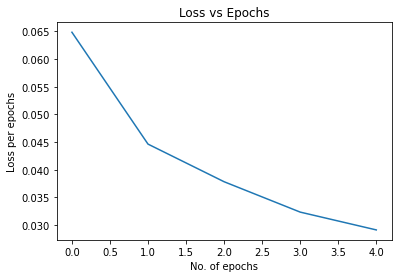

In [12]:
#Graph between loss and no. of epochs
plt.plot(np.arange(num_epochs),loss_array)
plt.xlabel('No. of epochs')
plt.ylabel('Loss per epochs')
plt.title('Loss vs Epochs')
plt.show()
#We can see that as the number epochs increases the value of loss function decreases